## Detalle sobre este notebook (fv_periodo):
* Este notebook utiliza los programas presidenciales del cualquier período de 5 años, los compara según su correlación por temas etiquetados, por país.
* Selecciona un Feature Vector acotado
* Construye una red de similaridad.
* Luego identifica comunidades.
* Luego estima métricas de centralidad
* al final tiene conclusiones sobre el período #15 (1990-1994)

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.00000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Albania,16,3.716797,0.00000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Albania,17,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Argentina,14,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.0,0.326532,0.0,0.000000,0.0,0.0,0.0,2.495280,0.0
4,Argentina,16,0.254185,0.02014,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.0,0.443809,0.0,0.809128,0.0,0.0,0.0,2.573783,0.0


In [3]:
df_5_extended.shape

(1407, 144)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [6]:
len(all_per_variables)

142

#### 1. TRABAJO CON ASPECTOS PARTICULARES
   * Crearemos una lista de nombres de 'aspectos' junto con una lista de nombres de variables que lo explican
   * Consolidaremos 'df_5_extended' para que incluya solamente las volumnas de interés para cada aspecto.


#### 1.1 Lista de aspectos y variables de interés
* Aspecto específicos:
       
*          * Inclusión y Minorías
*          * Orden y Corrupción
*          * Medio Ambiente y Sostenibilidad
*          * Pueblos Originarios
*          * Derechos Humanos
*          * Inmigración
*          * Moral Tradicional 


#### Correlación de Pearson

**Qué es**: La correlación de Pearson mide la relación lineal entre dos conjuntos de datos. En este caso, mediría cómo se correlacionan los porcentajes de las etiquetas temáticas entre dos programas de gobierno.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), calcula la correlación de Pearson usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es `[x1,x2,...,x56]` y el de "Alemania_1980" es `[y1,y2,...,y56]`, entonces la correlación de Pearson se calcula como:

$$
r = \frac{\sum_{i=1}^{56} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{56} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{56} (y_i - \bar{y})^2}}
$$

Donde $\bar{x}$ y $\bar{y}$ son las medias de los vectores de porcentajes.

#### Interpretación de la Correlación:
El valor de $r$ está en el rango $[-1,1]$, donde:

- $r = 1$ indica una correlación positiva perfecta (discursos muy similares en la distribución temática).
- $r = -1$ indica una correlación negativa perfecta (discursos temáticamente opuestos).
- $r \approx 0$ indica que no hay una correlación lineal significativa.

#### Uso en la Red de Similaridad:
Usaremos el valor absoluto de la correlación ($|r|$) para ponderar la arista entre dos programas. Valores cercanos a 1 indican una fuerte similaridad temática, mientras que valores cercanos a 0 indican poca o ninguna similaridad.

---


#### Distancia Euclidiana

**Qué es**: La distancia euclidiana es una medida de disimilitud que calcula la distancia entre dos puntos en un espacio n-dimensional. En este caso, mide la distancia entre los vectores de porcentajes de etiquetas temáticas de dos programas de gobierno. A diferencia de la correlación, la distancia euclidiana se centra en la magnitud de las diferencias entre los temas, sin considerar relaciones lineales.

**Aplicación**: Para cada par de programas de gobierno (por ejemplo, "Chile_1990" y "Alemania_1980"), se calcula la distancia euclidiana usando sus respectivos vectores de porcentajes de las 56 etiquetas temáticas.

Si el vector de "Chile_1990" es \([x_1, x_2, ..., x_{56}]\) y el de "Alemania_1980" es \([y_1, y_2, ..., y_{56}]\), entonces la distancia euclidiana se calcula como:

$$
d = \sqrt{\sum_{i=1}^{56} (x_i - y_i)^2}
$$

#### Interpretación de la Distancia Euclidiana:
El valor de \(d\) está en el rango \([0, +\infty)\), donde:

- \(d = 0\) indica una similaridad perfecta, es decir, los programas tienen exactamente la misma distribución temática.
- Un valor mayor de \(d\) indica una mayor disimilitud entre los programas, es decir, sus distribuciones temáticas difieren más.

#### Uso en la Red de Similaridad:
Para obtener una medida de similaridad a partir de la distancia, podemos transformarla como:

$$
\text{similaridad} = \frac{1}{1 + d}
$$

Esto convierte la distancia en una escala inversa de similaridad, donde valores más cercanos a 1 indican alta similaridad temática y valores más cercanos a 0 indican baja similaridad.

---


### MATRIZ DE ASPECTOS

In [12]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['Inclusion_y_Minorias', 'Orden_y_Corrupcion', 'Medio_Ambiente_y_Sostenibilidad', 'Pueblos_Originarios'],
    'var_1': ['per503', 'per605_1', 'per501', 'per607_3'],
    'var_2': ['per705', 'per605_2', 'per416_2', 'per608_3'],
    'var_3': ['per201_2', 'per304', None, None],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None, None, None, None]  # Ningún aspecto tiene cuarta variable
    # 'var_3': ['per201_2', 'per304', None, None],
    # 'var_3': ['None', 'per304', None, None],  # None indica que no hay una tercera variable para el aspecto
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

,aspecto,var_1,var_2,var_3,var_4
0,Inclusion_y_Minorias,per503,per705,per201_2,None
1,Orden_y_Corrupcion,per605_1,per605_2,per304,None
2,Medio_Ambiente_y_Sostenibilidad,per501,per416_2,None,None
3,Pueblos_Originarios,per607_3,per608_3,None,None


#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [13]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from collections import defaultdict
import itertools


In [14]:
def calcular_similitudes_todos_paises(df, df_aspectos, tipo_similitud, periodo):
    """Calcula la similaridad entre todos los países para un aspecto específico y un período usando Pearson o Euclidean."""
    similarity_results = defaultdict(list)

    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()

        # Filtrar datos de todos los países con las columnas relevantes
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_filtered = df[columnas_relevantes].copy()

        # Calcular similitudes entre todos los pares de países
        for (idx1, row1), (idx2, row2) in itertools.combinations(df_filtered.iterrows(), 2):
            country_period_1 = f"{row1['countryname']}_{row1['ventana_5']}"
            country_data_1 = row1[variables].astype(float)

            country_period_2 = f"{row2['countryname']}_{row2['ventana_5']}"
            country_data_2 = row2[variables].astype(float)

            # Asignar similaridad de cero si uno de los países tiene todos los valores en cero
            if country_data_1.sum() == 0 or country_data_2.sum() == 0:
                similarity = 0  
            else:
                if tipo_similitud == 'pearson':
                    # Calcular la correlación de Pearson
                    corr = country_data_1.corr(country_data_2, method='pearson')
                    # print(f"Pearson/ {aspecto} / {country_period_1} / {country_period_2} / {corr}")
                    similarity = 0 if pd.isna(corr) else abs(corr)
                elif tipo_similitud == 'euclidean':
                    dist = euclidean(country_data_1, country_data_2)
                    similarity = 1 / (1 + dist) if not np.isnan(dist) else 0

            similarity_results[(aspecto, country_period_1, country_period_2)].append(similarity)

    # Convertir a DataFrame
    final_results = {
        key: np.mean(values) for key, values in similarity_results.items()
    }

    df_similarities = pd.DataFrame(
        list(final_results.items()), 
        columns=['Aspecto_Country_Period1_Period2', 'Similarity']
    )
    df_similarities[['Aspecto', 'Country_Period_1', 'Country_Period_2']] = pd.DataFrame(
        df_similarities['Aspecto_Country_Period1_Period2'].tolist(), index=df_similarities.index
    )
    df_similarities.drop('Aspecto_Country_Period1_Period2', axis=1, inplace=True)

    # Eliminar duplicados
    df_similarities = df_similarities.groupby(['Country_Period_1', 'Country_Period_2'], as_index=False).agg({'Similarity': 'mean'})
    
    return df_similarities


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [15]:
def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Genera una red de similaridad, calcula las métricas de centralidad, 
    y analiza las comunidades detectadas para un aspecto específico.
    """
    resumen = {'Aspecto': aspecto, 'Criterio': tipo_similitud}
    
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Redondear la similaridad a 4 decimales
    df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
    
    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])
    
    # Configuración de colores de los enlaces según la fuerza del enlace
    weights = nx.get_edge_attributes(G, 'weight').values()
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = [cm.coolwarm(norm(weight)) for weight in weights]

    # Visualización de la red de similaridad
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Red de Similitud - {aspecto}\nPeríodo {periodo} ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.show()

    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    resumen['Num_Comunidades'] = len(partition)
    print(f"Se identificaron {resumen['Num_Comunidades']} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = cm.rainbow(np.linspace(0, 1, resumen['Num_Comunidades']))  # Colores para cada comunidad
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, node_color=[colors[i]], label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto}\nPeríodo {periodo} ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.legend(loc="best")
    plt.show()

    # Identificar la comunidad de Chile
    chile_node = f"Chile_{periodo}"
    chile_community = None
    for i, comm in enumerate(partition):
        if chile_node in comm:
            chile_community = comm
            resumen['Comunidad_Chile'] = i
            resumen['Num_Paises_Chile_Comunidad'] = len(chile_community)
            print(f"Chile pertenece a la Comunidad {i}, que incluye {len(chile_community)} países:")
            print(sorted(list(chile_community)))
            break
    if not chile_community:
        resumen['Comunidad_Chile'] = None
        resumen['Num_Paises_Chile_Comunidad'] = 0

    # Listar otras comunidades
    for i, comm in enumerate(partition):
        if chile_node not in comm:
            print(f"Comunidad {i} incluye {len(comm)} países:")
            print(sorted(list(comm)))

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })
    
    resumen['Num_Paises'] = len(centralities)
    for metric in ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality', 'Eigenvector_Centrality']:
        resumen[f'Promedio_{metric}'] = round(centralities[metric].mean(), 4)
        resumen[f'Std_{metric}'] = round(centralities[metric].std(), 4)
        resumen[f'Max_{metric}'] = round(centralities[metric].max(), 4)

    return resumen, centralities


#### Ejecución


=== Análisis para el aspecto: Inclusion_y_Minorias ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


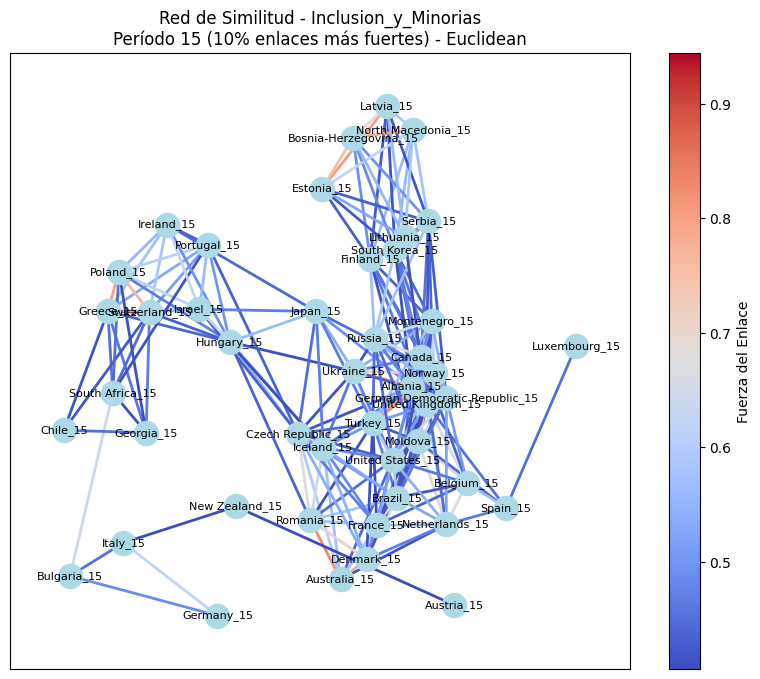

Se identificaron 5 clusters para el aspecto 'Inclusion_y_Minorias'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


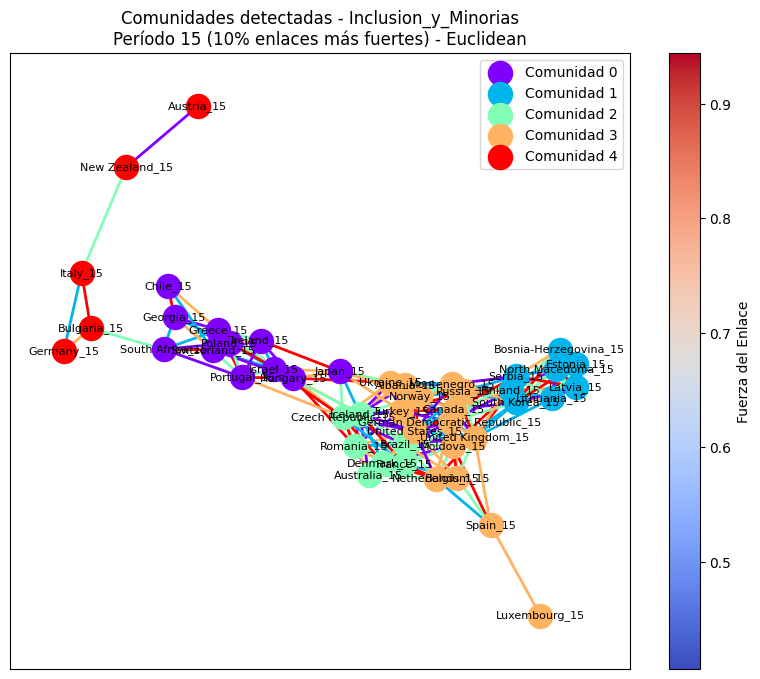

Chile pertenece a la Comunidad 0, que incluye 11 países:
['Chile_15', 'Georgia_15', 'Greece_15', 'Hungary_15', 'Ireland_15', 'Israel_15', 'Japan_15', 'Poland_15', 'Portugal_15', 'South Africa_15', 'Switzerland_15']
Comunidad 1 incluye 8 países:
['Bosnia-Herzegovina_15', 'Estonia_15', 'Finland_15', 'Latvia_15', 'Lithuania_15', 'North Macedonia_15', 'Serbia_15', 'South Korea_15']
Comunidad 2 incluye 7 países:
['Australia_15', 'Brazil_15', 'Czech Republic_15', 'Denmark_15', 'France_15', 'Iceland_15', 'Romania_15']
Comunidad 3 incluye 15 países:
['Albania_15', 'Belgium_15', 'Canada_15', 'German Democratic Republic_15', 'Luxembourg_15', 'Moldova_15', 'Montenegro_15', 'Netherlands_15', 'Norway_15', 'Russia_15', 'Spain_15', 'Turkey_15', 'Ukraine_15', 'United Kingdom_15', 'United States_15']
Comunidad 4 incluye 5 países:
['Austria_15', 'Bulgaria_15', 'Germany_15', 'Italy_15', 'New Zealand_15']

=== Análisis para el aspecto: Orden_y_Corrupcion ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


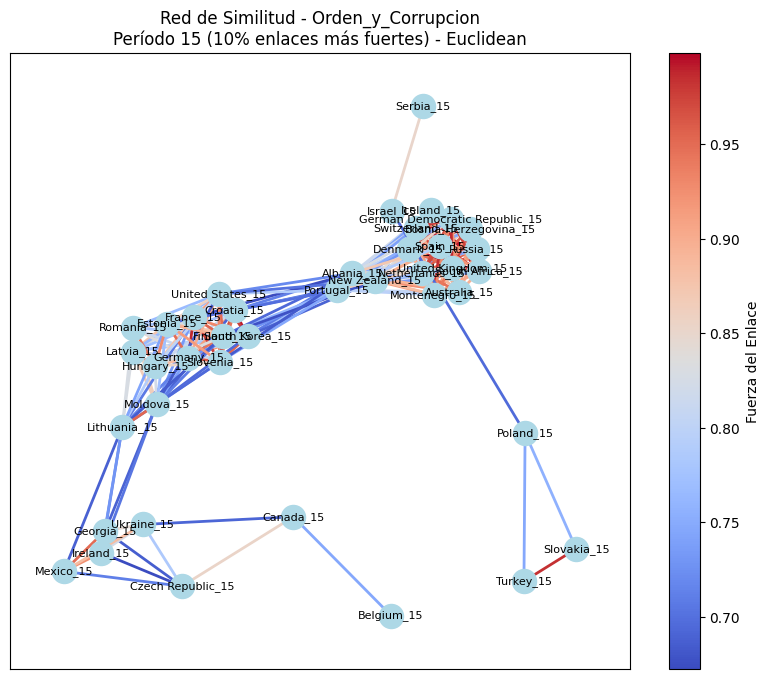

Se identificaron 4 clusters para el aspecto 'Orden_y_Corrupcion'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


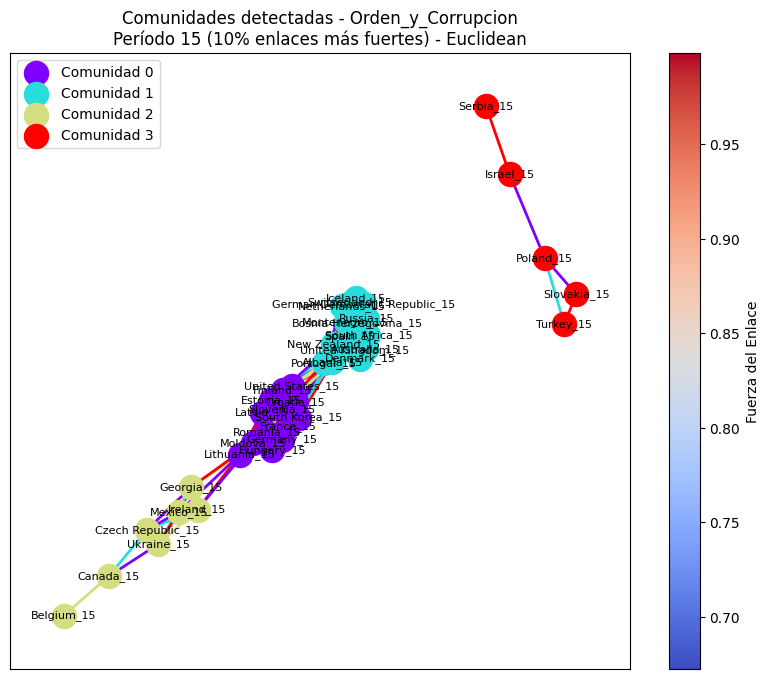

Comunidad 0 incluye 13 países:
['Croatia_15', 'Estonia_15', 'Finland_15', 'France_15', 'Germany_15', 'Hungary_15', 'Latvia_15', 'Lithuania_15', 'Moldova_15', 'Romania_15', 'Slovenia_15', 'South Korea_15', 'United States_15']
Comunidad 1 incluye 15 países:
['Albania_15', 'Australia_15', 'Bosnia-Herzegovina_15', 'Denmark_15', 'German Democratic Republic_15', 'Iceland_15', 'Montenegro_15', 'Netherlands_15', 'New Zealand_15', 'Portugal_15', 'Russia_15', 'South Africa_15', 'Spain_15', 'Switzerland_15', 'United Kingdom_15']
Comunidad 2 incluye 7 países:
['Belgium_15', 'Canada_15', 'Czech Republic_15', 'Georgia_15', 'Ireland_15', 'Mexico_15', 'Ukraine_15']
Comunidad 3 incluye 5 países:
['Israel_15', 'Poland_15', 'Serbia_15', 'Slovakia_15', 'Turkey_15']

=== Análisis para el aspecto: Medio_Ambiente_y_Sostenibilidad ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


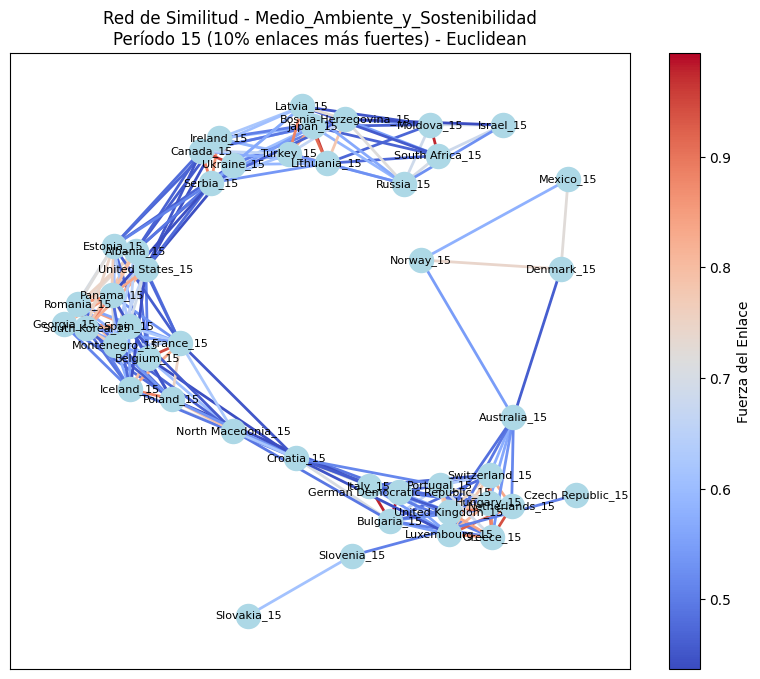

Se identificaron 4 clusters para el aspecto 'Medio_Ambiente_y_Sostenibilidad'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


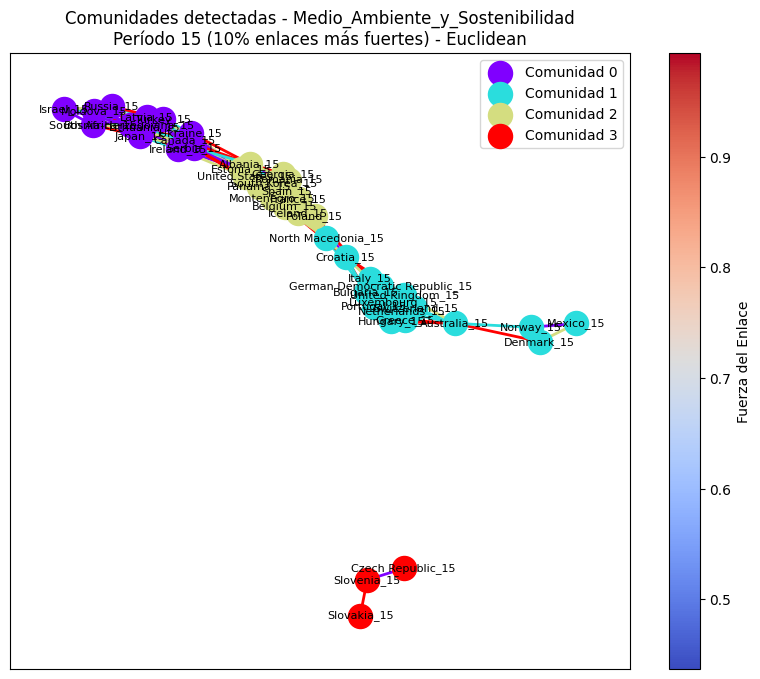

Comunidad 0 incluye 13 países:
['Bosnia-Herzegovina_15', 'Canada_15', 'Ireland_15', 'Israel_15', 'Japan_15', 'Latvia_15', 'Lithuania_15', 'Moldova_15', 'Russia_15', 'Serbia_15', 'South Africa_15', 'Turkey_15', 'Ukraine_15']
Comunidad 1 incluye 16 países:
['Australia_15', 'Bulgaria_15', 'Croatia_15', 'Denmark_15', 'German Democratic Republic_15', 'Greece_15', 'Hungary_15', 'Italy_15', 'Luxembourg_15', 'Mexico_15', 'Netherlands_15', 'North Macedonia_15', 'Norway_15', 'Portugal_15', 'Switzerland_15', 'United Kingdom_15']
Comunidad 2 incluye 13 países:
['Albania_15', 'Belgium_15', 'Estonia_15', 'France_15', 'Georgia_15', 'Iceland_15', 'Montenegro_15', 'Panama_15', 'Poland_15', 'Romania_15', 'South Korea_15', 'Spain_15', 'United States_15']
Comunidad 3 incluye 3 países:
['Czech Republic_15', 'Slovakia_15', 'Slovenia_15']

=== Análisis para el aspecto: Pueblos_Originarios ===



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:37: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


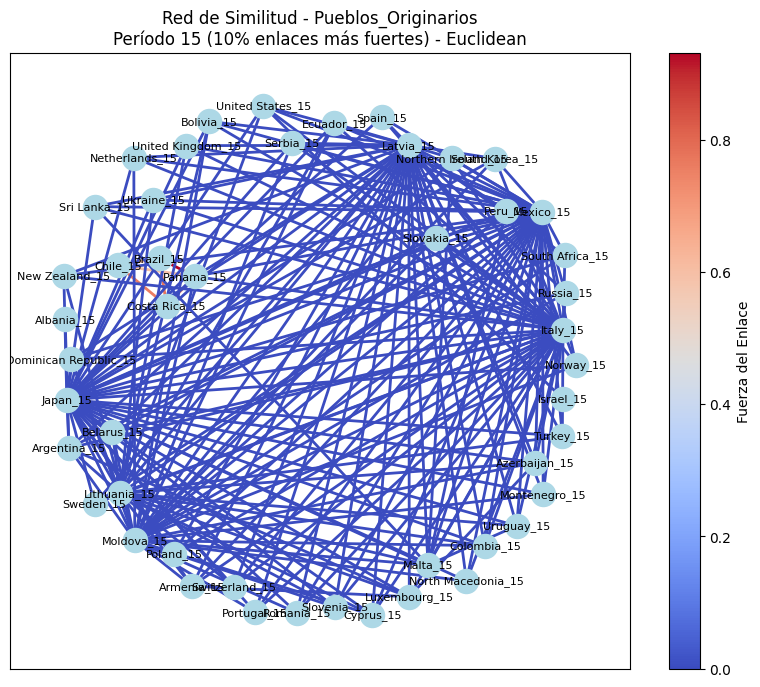

Se identificaron 45 clusters para el aspecto 'Pueblos_Originarios'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/730928281.py:56: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


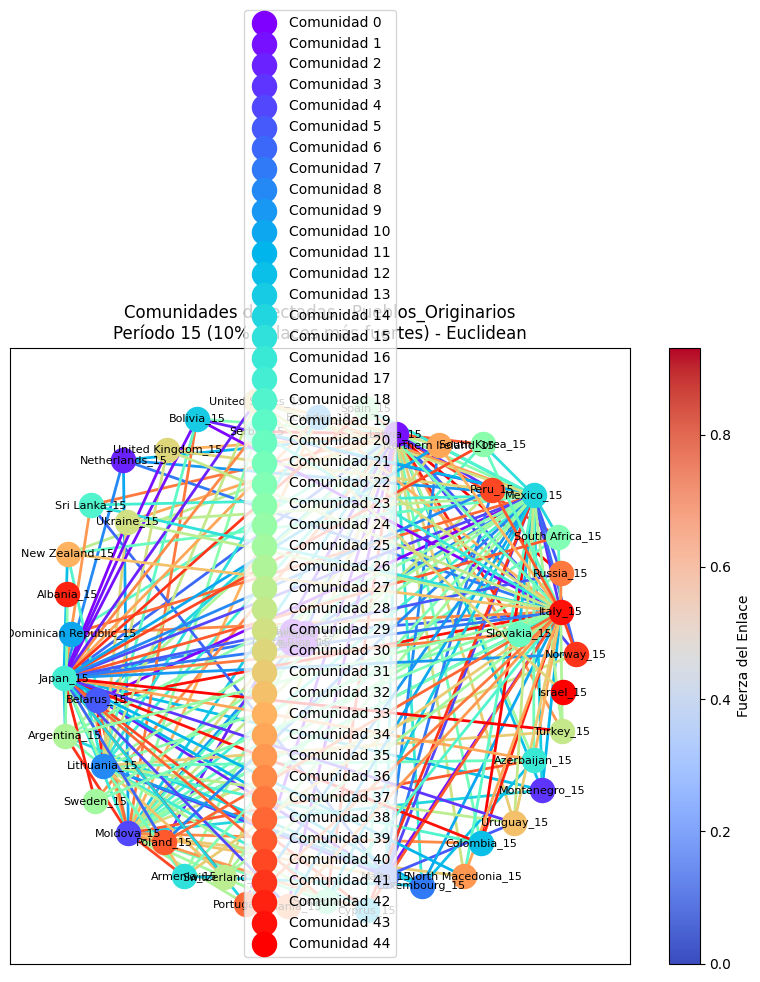

Chile pertenece a la Comunidad 0, que incluye 4 países:
['Brazil_15', 'Chile_15', 'Costa Rica_15', 'Panama_15']
Comunidad 1 incluye 1 países:
['Latvia_15']
Comunidad 2 incluye 1 países:
['Netherlands_15']
Comunidad 3 incluye 1 países:
['Montenegro_15']
Comunidad 4 incluye 1 países:
['Moldova_15']
Comunidad 5 incluye 1 países:
['Belarus_15']
Comunidad 6 incluye 1 países:
['Malta_15']
Comunidad 7 incluye 1 países:
['Luxembourg_15']
Comunidad 8 incluye 1 países:
['Lithuania_15']
Comunidad 9 incluye 1 países:
['Ecuador_15']
Comunidad 10 incluye 1 países:
['Dominican Republic_15']
Comunidad 11 incluye 1 países:
['Cyprus_15']
Comunidad 12 incluye 1 países:
['Colombia_15']
Comunidad 13 incluye 1 países:
['Bolivia_15']
Comunidad 14 incluye 1 países:
['Mexico_15']
Comunidad 15 incluye 1 países:
['Armenia_15']
Comunidad 16 incluye 1 países:
['Azerbaijan_15']
Comunidad 17 incluye 1 países:
['Japan_15']
Comunidad 18 incluye 1 países:
['Sri Lanka_15']
Comunidad 19 incluye 1 países:
['Serbia_15']
Co

,Aspecto,Criterio,Num_Comunidades,Comunidad_Chile,Num_Paises_Chile_Comunidad,Num_Paises,Promedio_Degree_Centrality,Std_Degree_Centrality,Max_Degree_Centrality,Promedio_Betweenness_Centrality,Std_Betweenness_Centrality,Max_Betweenness_Centrality,Promedio_Closeness_Centrality,Std_Closeness_Centrality,Max_Closeness_Centrality,Promedio_Eigenvector_Centrality,Std_Eigenvector_Centrality,Max_Eigenvector_Centrality
0,Inclusion_y_Minorias,Euclidean,5,0.0,11,46,0.2135,0.1033,0.4222,4.930000e-02,6.540000e-02,2.424000e-01,0.3385,0.0771,0.4412,0.1139,0.0946,0.2932
1,Orden_y_Corrupcion,Euclidean,4,NaN,0,40,0.2833,0.1404,0.5641,2.800000e-02,6.440000e-02,3.293000e-01,0.3484,0.1340,0.4940,0.1268,0.0956,0.2890
2,Medio_Ambiente_y_Sostenibilidad,Euclidean,4,NaN,0,45,0.2232,0.0845,0.3409,4.180000e-02,6.000000e-02,2.484000e-01,0.3017,0.0951,0.4108,0.1126,0.0987,0.2729
3,Pueblos_Originarios,Euclidean,45,0.0,4,48,0.1959,0.2329,0.8936,3.094291e+09,1.227553e+10,7.468534e+10,0.5290,0.1292,0.9038,0.1209,0.0796,0.3405


In [16]:
# Parámetros de ejecución
periodo = 15
porcentaje = 10
pearsonsino = False  # Cambiar a False para omitir el análisis de Pearson

# Lista para almacenar los resúmenes
resumen_aspectos = []

# Iterar sobre todos los aspectos en el DataFrame df_aspectos
for aspecto in df_aspectos['aspecto']:
    print(f"\n=== Análisis para el aspecto: {aspecto} ===\n")
    
    if pearsonsino:
        # Calcular similitudes usando Pearson
        df_similarity_pearson = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='pearson', 
            periodo=periodo
        )
        resumen_pearson, _ = generar_red_y_calcular_metricas(
            df_similarity_pearson, 
            aspecto=aspecto, 
            tipo_similitud='Pearson', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        resumen_aspectos.append(resumen_pearson)
    
    # Calcular similitudes usando Euclidean
    df_similarity_euclidean = calcular_similitudes_todos_paises(
        df_5_extended, 
        df_aspectos[df_aspectos['aspecto'] == aspecto], 
        tipo_similitud='euclidean', 
        periodo=periodo
    )
    resumen_euclidean, _ = generar_red_y_calcular_metricas(
        df_similarity_euclidean, 
        aspecto=aspecto, 
        tipo_similitud='Euclidean', 
        porcentaje=porcentaje, 
        periodo=periodo
    )
    resumen_aspectos.append(resumen_euclidean)

# Crear el DataFrame resumen
df_resumen = pd.DataFrame(resumen_aspectos)

# Mostrar el resumen
display(df_resumen)


#### VEAMOS CÓMO SE DISTRIBUYEN LAS MÉTRICAS DE CENTRALIDAD PARA VER SI HAY NODOS QUE MUESTREN EXCEPCIONALIDADES


=== Distribución de centralidades para el aspecto: Inclusion_y_Minorias ===



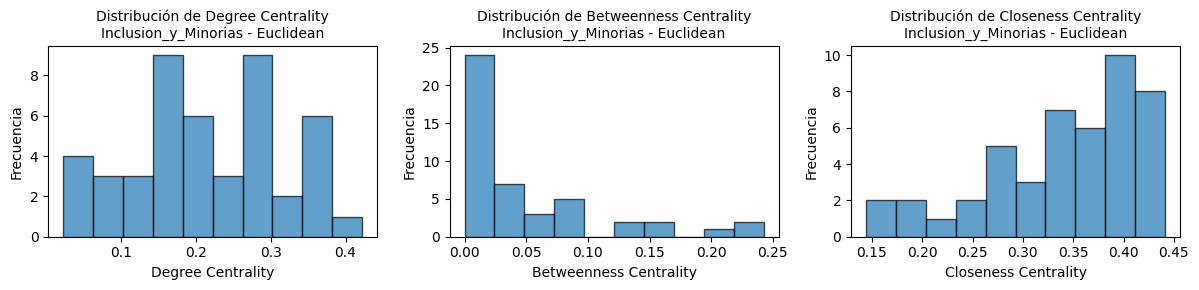


=== Distribución de centralidades para el aspecto: Orden_y_Corrupcion ===



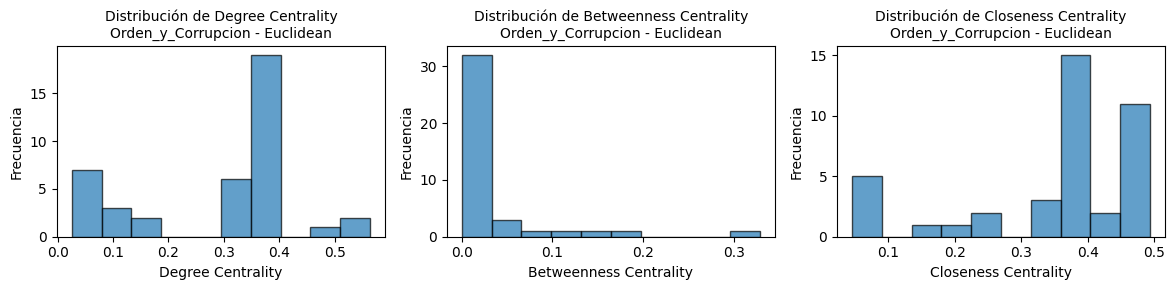


=== Distribución de centralidades para el aspecto: Medio_Ambiente_y_Sostenibilidad ===



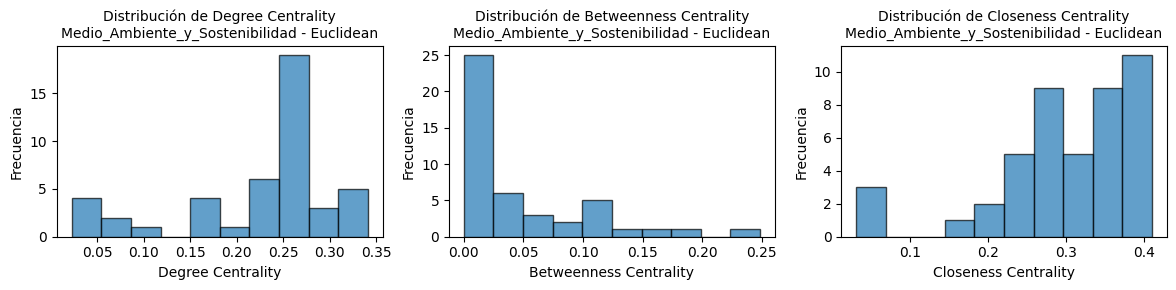


=== Distribución de centralidades para el aspecto: Pueblos_Originarios ===



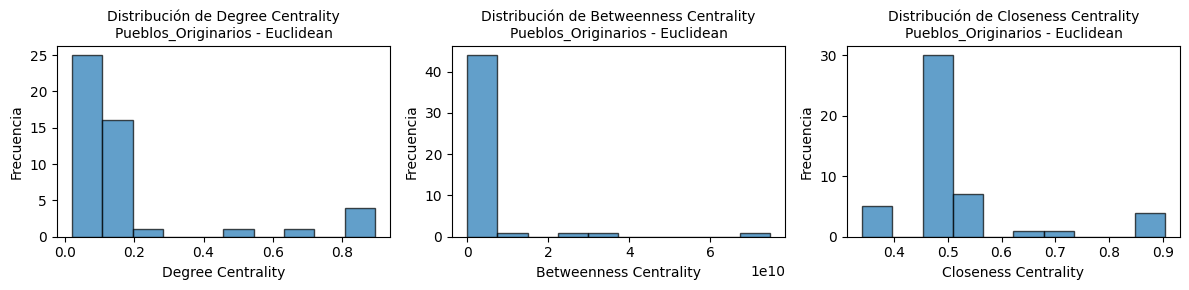

In [17]:
import matplotlib.pyplot as plt

def calcular_centralidades(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Calcula las métricas de centralidad para un grafo construido a partir de las similitudes.
    """
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])

    # Calcular métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })

    return centralities


def graficar_distribucion_centralidades(df_centralities, aspecto, tipo_similitud, titulo_fontsize=10):
    """Grafica la distribución de las centralidades para un aspecto específico."""
    metrics = ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality'] #, 'Eigenvector_Centrality']
    num_metrics = len(metrics)
    
    plt.figure(figsize=(12, 3))
    for i, metric in enumerate(metrics):
        plt.subplot(1, num_metrics, i + 1)
        plt.hist(df_centralities[metric], bins=10, edgecolor='black', alpha=0.7)
        plt.title(f'Distribución de {metric.replace("_", " ")}\n{aspecto} - {tipo_similitud}', fontsize=titulo_fontsize)
        plt.xlabel(metric.replace("_", " "))
        plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

# Ejecución para graficar distribuciones
for aspecto in df_aspectos['aspecto']:
    print(f"\n=== Distribución de centralidades para el aspecto: {aspecto} ===\n")
    
    if pearsonsino:
        df_similarity_pearson = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='pearson', 
            periodo=periodo
        )
        centralities_pearson = calcular_centralidades(
            df_similarity_pearson, 
            aspecto=aspecto, 
            tipo_similitud='Pearson', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        graficar_distribucion_centralidades(centralities_pearson, aspecto, 'Pearson', titulo_fontsize=10)
    
    df_similarity_euclidean = calcular_similitudes_todos_paises(
        df_5_extended, 
        df_aspectos[df_aspectos['aspecto'] == aspecto], 
        tipo_similitud='euclidean', 
        periodo=periodo
    )
    centralities_euclidean = calcular_centralidades(
        df_similarity_euclidean, 
        aspecto=aspecto, 
        tipo_similitud='Euclidean', 
        porcentaje=porcentaje, 
        periodo=periodo
    )
    graficar_distribucion_centralidades(centralities_euclidean, aspecto, 'Euclidean', titulo_fontsize=10)


#### Analicemos un aspecto en particular para ver la dispersión de las variables que componen el aspecto. Elegiremos 'Medio Ambiente y Sostenibilidad' que tiene 2 variables que lo caracterizan (per501 y per416_2). 
#### Utilizaremos la data de 'df_5_extended' para un período en particular. Los datos que hay en 'df_5_extended' corresponden a 1 registro por agno para cada país, sumando las etiquetas (%) de los programas del país ponderadas por las columnas 'persvote' o 'pervote' (ver notebook 'Correlaciones_aspectos.ipynb').

In [18]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()

,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


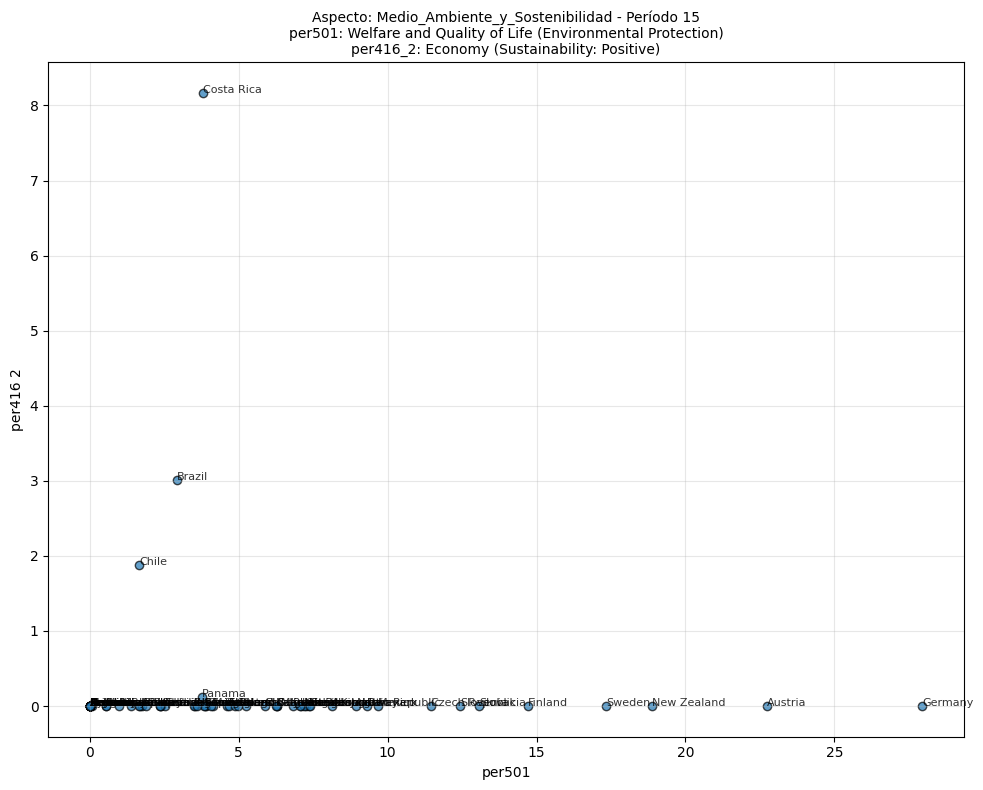

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/174948929.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data.rename(columns={'countryname': 'País'}, inplace=True)


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar las variables asociadas al aspecto 'Medio_Ambiente_y_Sostenibilidad'
aspecto_filtro = 'Medio_Ambiente_y_Sostenibilidad'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2']].dropna().values.flatten()

# Obtener los dominios y detalles asociados a las variables
df_variables_info = df_AD[df_AD['Variable_per'].isin(variables)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]

# Crear la descripción del título con las variables y sus dominios
variables_descripcion = "\n".join([
    f"{row['Variable_per']}: {row['Nombre_Dominio']} ({row['Detalle_Dominio']})"
    for _, row in df_variables_info.iterrows()
])

# Filtrar el dataframe con las variables seleccionadas
df_filtered = df_5_extended[['countryname', 'ventana_5'] + list(variables)].copy()
df_filtered = df_filtered[df_filtered['ventana_5'] == periodo]  # Filtrar por el período deseado

# Redondear los valores a 4 decimales
df_filtered[list(variables)] = df_filtered[list(variables)].round(4)

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 8))
plt.scatter(df_filtered[variables[0]], df_filtered[variables[1]], alpha=0.7, edgecolor='k')
for i, row in df_filtered.iterrows():
    plt.text(row[variables[0]], row[variables[1]], row['countryname'], fontsize=8, alpha=0.8)

# Incluir la descripción en el título
plt.title(f'Aspecto: {aspecto_filtro} - Período {periodo}\n{variables_descripcion}', fontsize=10)
plt.xlabel(variables[0].replace('_', ' '), fontsize=10)
plt.ylabel(variables[1].replace('_', ' '), fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Preparar la tabla como DataFrame filtrada por período
table_data = df_filtered[['countryname'] + list(variables)]
table_data.rename(columns={'countryname': 'País'}, inplace=True)



##### Comentario al gráfico de dispersión de 'Medio Ambiente y Sostenibilidad': 
* La variable per416_2 (Dominio: Economy, Descripción: Sustainability-Positive), tiene muchos datos en 0. 
* Esto hace pensar que esa variable es poco descriptiva del fenómenos que queremos analizar
* ELEGIR OTRA VARIABLE
* ANALIZAR EL PROGRAMAA DE COSTA RICA en el período 15.

In [20]:
table_data

,País,per501,per416_2
0,Albania,3.5453,0.0
24,Australia,8.1254,0.0
40,Austria,22.7425,0.0
58,Belgium,4.6020,0.0
66,Bosnia-Herzegovina,1.3774,0.0
...,...,...,...
1076,Malta,0.0000,0.0
1146,Northern Ireland,0.0000,0.0
1188,Peru,0.0000,0.0
1342,Sri Lanka,0.0000,0.0


#### Analicemos 'Inclusión y Minorías' sólo con dos variables ya que la tercera es poco informada. Chile aparece en rojo

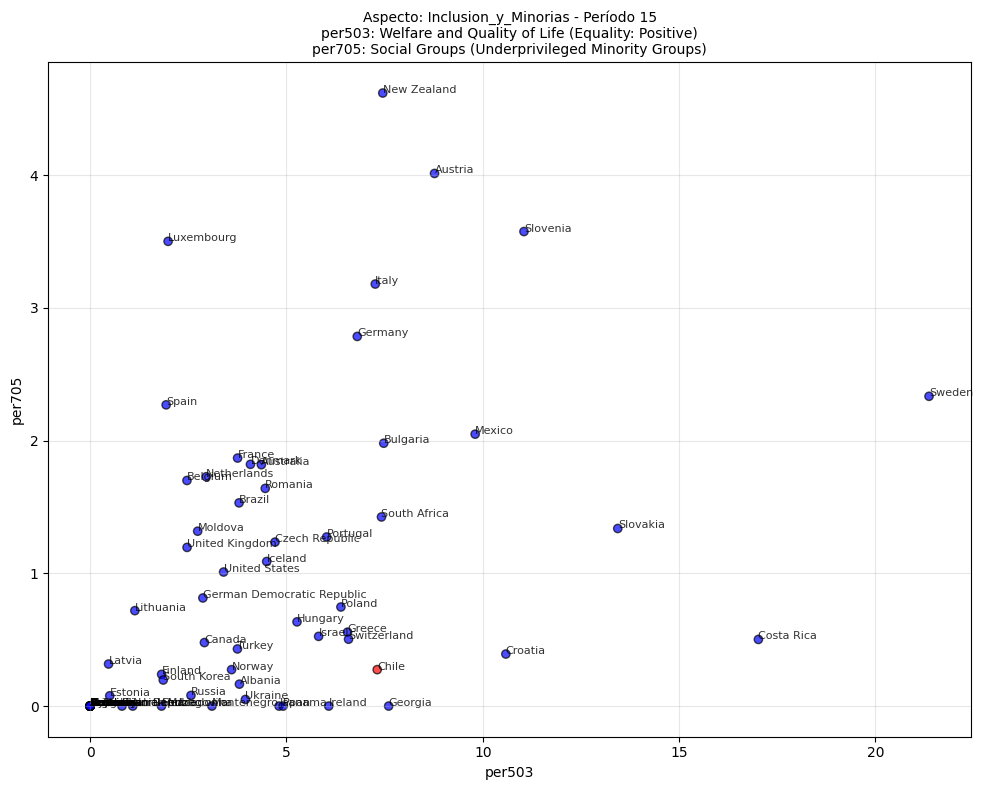

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/3769554959.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data.rename(columns={'countryname': 'País'}, inplace=True)


In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Filtrar las variables asociadas al aspecto 'Inclusion_y_Minorias'
aspecto_filtro = 'Inclusion_y_Minorias'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2']].dropna().values.flatten()

# Obtener los dominios y detalles asociados a las variables
df_variables_info = df_AD[df_AD['Variable_per'].isin(variables)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]

# Crear la descripción del título con las variables y sus dominios
variables_descripcion = "\n".join([
    f"{row['Variable_per']}: {row['Nombre_Dominio']} ({row['Detalle_Dominio']})"
    for _, row in df_variables_info.iterrows()
])

# Filtrar el dataframe con las variables seleccionadas
df_filtered = df_5_extended[['countryname', 'ventana_5'] + list(variables)].copy()
df_filtered = df_filtered[df_filtered['ventana_5'] == periodo]  # Filtrar por el período deseado

# Redondear los valores a 4 decimales
df_filtered[list(variables)] = df_filtered[list(variables)].round(4)

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 8))

# Asignar colores: rojo para Chile, azul para otros países
colors = ['red' if country == 'Chile' else 'blue' for country in df_filtered['countryname']]
plt.scatter(df_filtered[variables[0]], df_filtered[variables[1]], c=colors, alpha=0.7, edgecolor='k')

# Añadir etiquetas para los puntos
for i, row in df_filtered.iterrows():
    plt.text(row[variables[0]], row[variables[1]], row['countryname'], fontsize=8, alpha=0.8)

# Configurar título y etiquetas
plt.title(f'Aspecto: {aspecto_filtro} - Período {periodo}\n{variables_descripcion}', fontsize=10)
plt.xlabel(variables[0].replace('_', ' '), fontsize=10)
plt.ylabel(variables[1].replace('_', ' '), fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Preparar la tabla como DataFrame filtrada por período
table_data = df_filtered[['countryname'] + list(variables)]
table_data.rename(columns={'countryname': 'País'}, inplace=True)

# Mostrar la tabla



#### Analicemos la dispersión de un aspecto descritp por 3 variables: 

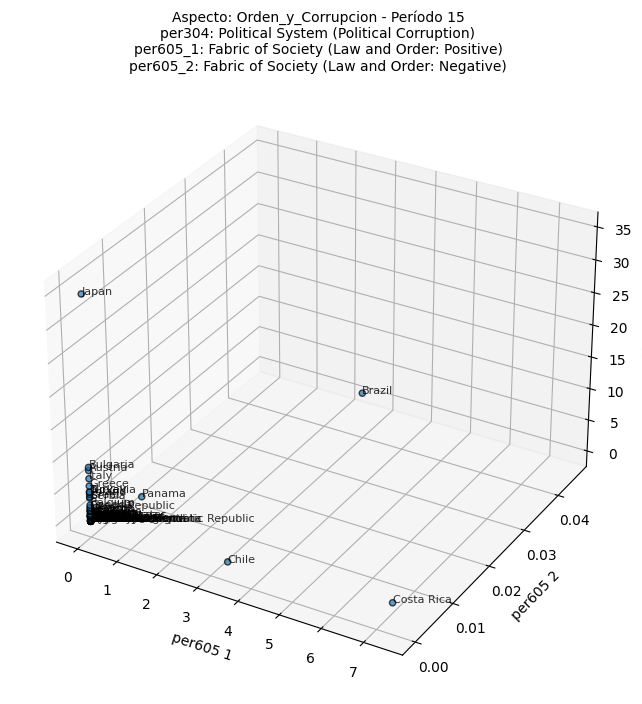

/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_1177/1170096269.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data.rename(columns={'countryname': 'País'}, inplace=True)


,País,per605_1,per605_2,per304
0,Albania,0.0,0.0,0.2761
24,Australia,0.0,0.0,0.1565
40,Austria,0.0,0.0,7.9698
58,Belgium,0.0,0.0,2.5451
66,Bosnia-Herzegovina,0.0,0.0,0.0565
...,...,...,...,...
1076,Malta,0.0,0.0,0.0000
1146,Northern Ireland,0.0,0.0,0.0000
1188,Peru,0.0,0.0,0.0000
1342,Sri Lanka,0.0,0.0,0.0000


In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Filtrar las variables asociadas al aspecto
aspecto_filtro = 'Orden_y_Corrupcion'  # Cambiar al aspecto deseado
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][['var_1', 'var_2', 'var_3']].dropna().values.flatten()

# Obtener los dominios y detalles asociados a las variables
df_variables_info = df_AD[df_AD['Variable_per'].isin(variables)][['Variable_per', 'Nombre_Dominio', 'Detalle_Dominio']]

# Crear la descripción del título con las variables y sus dominios
variables_descripcion = "\n".join([
    f"{row['Variable_per']}: {row['Nombre_Dominio']} ({row['Detalle_Dominio']})"
    for _, row in df_variables_info.iterrows()
])

# Filtrar el dataframe con las variables seleccionadas
df_filtered = df_5_extended[['countryname', 'ventana_5'] + list(variables)].copy()
df_filtered = df_filtered[df_filtered['ventana_5'] == periodo]  # Filtrar por el período deseado

# Redondear los valores a 4 decimales
df_filtered[list(variables)] = df_filtered[list(variables)].round(4)

# Crear el gráfico de dispersión 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extraer las variables y los países
x_var = variables[0]
y_var = variables[1]
z_var = variables[2]

# Añadir puntos al gráfico
ax.scatter(df_filtered[x_var], df_filtered[y_var], df_filtered[z_var], alpha=0.7, edgecolor='k')

# Añadir etiquetas para los puntos
for i, row in df_filtered.iterrows():
    ax.text(row[x_var], row[y_var], row[z_var], row['countryname'], fontsize=8, alpha=0.8)

# Configurar el título y las etiquetas de los ejes
ax.set_title(f'Aspecto: {aspecto_filtro} - Período {periodo}\n{variables_descripcion}', fontsize=10)
ax.set_xlabel(x_var.replace('_', ' '), fontsize=10)
ax.set_ylabel(y_var.replace('_', ' '), fontsize=10)
ax.set_zlabel(z_var.replace('_', ' '), fontsize=10)

plt.show()

# Preparar la tabla como DataFrame
table_data = df_filtered[['countryname'] + list(variables)]
table_data.rename(columns={'countryname': 'País'}, inplace=True)

# Mostrar la tabla
table_data
